<a href="https://colab.research.google.com/github/mifm/examples/blob/master/ed_win_with_topfarm_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## INSTALL ALL REQUIRED PACKAGES
import importlib
if not importlib.util.find_spec("py_wake"):
  !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git
if not importlib.util.find_spec("topfarm"):
  !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/TopFarm2.git
if not importlib.util.find_spec("ed_win"):
  !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/edwin.git#egg=ed_win[interarray]

In [2]:
## IMPORT ALL REQUIRED FUNCTIONS

import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
from openmdao.api import n2

from topfarm._topfarm import TopFarmProblem, TopFarmGroup
from topfarm.cost_models.cost_model_wrappers import CostModelComponent
from topfarm.plotting import XYPlotComp
from topfarm.cost_models.py_wake_wrapper import PyWakeAEPCostModelComponent
from topfarm import SpacingConstraint, XYBoundaryConstraint
from topfarm.cost_models.economic_models.dtu_wind_cm_main import economic_evaluation

from py_wake.examples.data.hornsrev1 import wt_x, wt_y, HornsrevV80, Hornsrev1Site
from py_wake import NOJ
from py_wake.utils.gradients import autograd

from ed_win.wind_farm_network import WindFarmNetwork

In [3]:
## SETUP OF WIND FARM MODEL

x_init = np.array(wt_x)[np.array([0, 1, 8, 9])]
y_init = np.array(wt_y)[np.array([0, 1, 8, 9])]
n_wt = len(x_init)
wt = HornsrevV80()
site = Hornsrev1Site()
wf_model = NOJ(site, wt)
aep = wf_model(wt_x, wt_y).aep()

/usr/local/lib/python3.10/dist-packages/py_wake/deficit_models/noj.py:88: UserWarning: The NOJ model is not representative of the setup used in the literature. For this, use py_wake.literature.noj.Jensen_1983 instead
  DeprecatedModel.__init__(self, 'py_wake.literature.noj.Jensen_1983')


In [22]:
## SETUP OF ELECTRICAL COLLECTION SYSTEM MODEL

turbines_pos=np.asarray([wt_x, wt_y]).T
substations_pos = np.asarray([[359470], [6153890]]).T

cables = np.array([[500, 3, 100], [800, 5, 150], [1000, 10, 250]])

wfn = WindFarmNetwork(turbines_pos=turbines_pos, substations_pos=substations_pos, cables=cables)
G = wfn.optimize(turbines_pos)
sum(length for _, _, length in G.edges(data='length'))

Solving with heuristic(cpew)



559550.3574206333

In [ ]:
G2

In [5]:
## SETUP OF ECONOMICAL MODEL

Drotor_vector = [wt.diameter()] * n_wt
power_rated_vector = [float(wt.power(20))*1e-6] * n_wt
hub_height_vector = [wt.hub_height()] * n_wt

# add additional cost model inputs for shore distance, energy price, project lifetime, rated rotor speed and water depth
distance_from_shore = 30         # [km]
energy_price = 0.4               # [Euro/kWh] What we get per kWh
project_duration = 20            # [years]
rated_rpm_array = [12] * n_wt    # [rpm]
# water_depth_array = [15] * n_wt  # [m]
eco_eval = economic_evaluation(distance_from_shore, energy_price, project_duration)

In [23]:
## SETUP OF WRAPPER FUNCTIONS

def waterdepth_func(x, y, **kwargs):
  # insert a good water depth model here
  return 20

def cable_func(x, y, **kwargs):
  G = wfn.optimize(turbines_pos= np.asarray([x, y]).T)
  return sum(length for _, _, length in G.edges(data='length'))

def npv_func(AEP, water_depth, **kwargs):
    eco_eval.calculate_npv(rated_rpm_array, Drotor_vector, power_rated_vector, hub_height_vector, water_depth, AEP/n_wt * np.ones(n_wt)*10**6)
    CAPEX = eco_eval.project_costs_sums["CAPEX"]
    OPEX = eco_eval.project_costs_sums["OPEX"]
    return [eco_eval.NPV, CAPEX, OPEX]

In [24]:
## SETUP OF COMPONENTS

aep_component = PyWakeAEPCostModelComponent(wf_model, n_wt, grad_method=autograd, objective=False)

water_depth_component = CostModelComponent(input_keys=[('x', x_init),('y', y_init)],
                                          n_wt=n_wt,
                                          cost_function=waterdepth_func,
                                          objective=False,
                                          output_keys=[('water_depth', np.zeros(n_wt))])

cable_component = CostModelComponent(input_keys=[('x', x_init),('y', y_init)],
                                     n_wt=n_wt,
                                     cost_function=cable_func,
                                     objective=False,
                                     output_keys=[('cable_length', 1000)])

npv_comp = CostModelComponent(input_keys=[('AEP', 0), ('water_depth', 30*np.ones(n_wt))],
                              n_wt=n_wt,
                              cost_function=npv_func,
                              objective=True,
                              maximize=True,
                              output_keys=[('npv', 0), ('CAPEX', 0), ('OPEX', 0)])

cost_comp = TopFarmGroup([aep_component, water_depth_component, cable_component, npv_comp])

In [25]:
## SETUP OF PROBLEM

problem = TopFarmProblem(design_vars={'x': x_init, 'y': y_init},
                  cost_comp=cost_comp,
                  constraints=[XYBoundaryConstraint(np.asarray([x_init, y_init]).T, boundary_type='rectangle'),
                              SpacingConstraint(4 * wt.diameter())],
                  plot_comp=XYPlotComp())

INFO: checking out_of_order


INFO:check_config:checking out_of_order


INFO: checking system


INFO:check_config:checking system


INFO: checking solvers


INFO:check_config:checking solvers


INFO: checking dup_inputs


INFO:check_config:checking dup_inputs


INFO: checking missing_recorders


INFO:check_config:checking missing_recorders


INFO: checking unserializable_options


INFO:check_config:checking unserializable_options


INFO: checking comp_has_no_outputs


INFO:check_config:checking comp_has_no_outputs


INFO: checking auto_ivc_warnings


INFO:check_config:checking auto_ivc_warnings


INFO: checking out_of_order


INFO:check_config:checking out_of_order


INFO: checking system


INFO:check_config:checking system


INFO: checking solvers


INFO:check_config:checking solvers


INFO: checking dup_inputs


INFO:check_config:checking dup_inputs


INFO: checking missing_recorders


INFO:check_config:checking missing_recorders


INFO: checking unserializable_options


INFO:check_config:checking unserializable_options


INFO: checking comp_has_no_outputs


INFO:check_config:checking comp_has_no_outputs


INFO: checking auto_ivc_warnings


INFO:check_config:checking auto_ivc_warnings


Solving with heuristic(cpew)



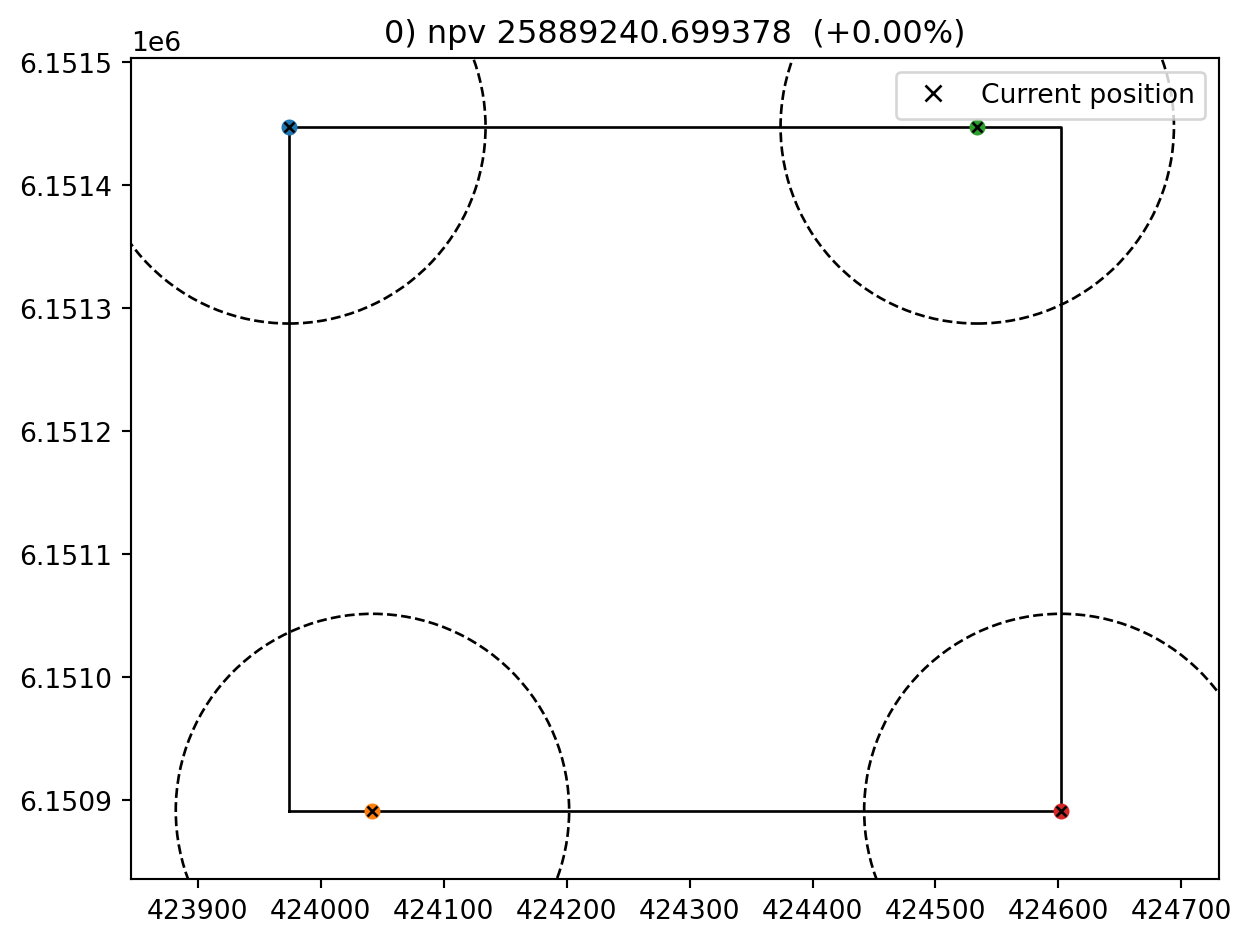

(-25889240.699377827,
 {'x': array([423974., 424042., 424534., 424602.]),
  'y': array([6151447., 6150891., 6151447., 6150891.])})

In [26]:
problem.evaluate()

INFO: checking out_of_order


INFO:check_config:checking out_of_order


INFO: checking system


INFO:check_config:checking system


INFO: checking solvers


INFO:check_config:checking solvers


INFO: checking dup_inputs


INFO:check_config:checking dup_inputs


INFO: checking missing_recorders


INFO:check_config:checking missing_recorders


INFO: checking unserializable_options


INFO:check_config:checking unserializable_options


INFO: checking comp_has_no_outputs


INFO:check_config:checking comp_has_no_outputs


INFO: checking auto_ivc_warnings


INFO:check_config:checking auto_ivc_warnings


Solving with heuristic(cpew)

Solving with heuristic(cpew)

Solving with heuristic(cpew)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -26108158.292387635
            Iterations: 6
            Function evaluations: 2
            Gradient evaluations: 2
Optimization Complete
-----------------------------------


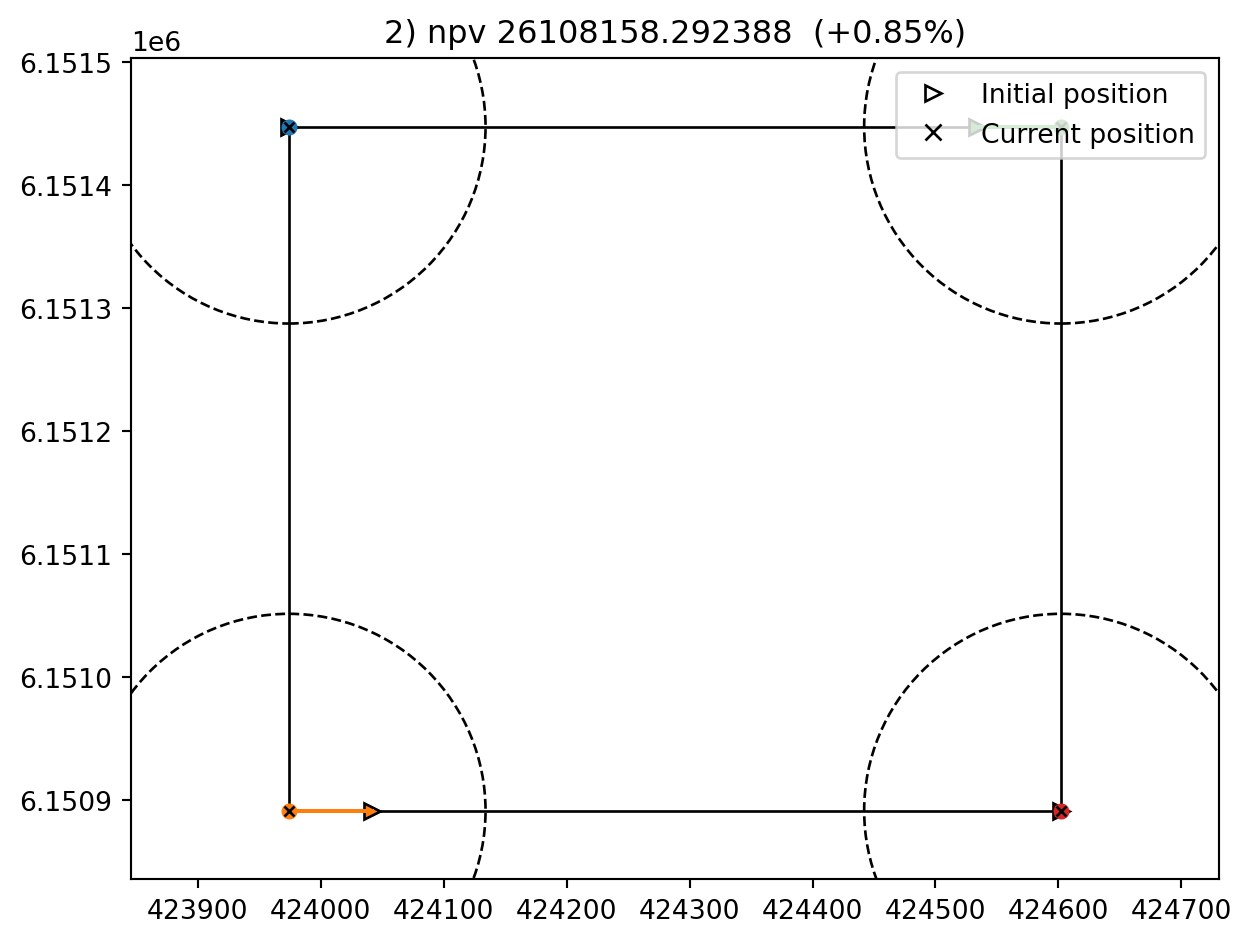

In [27]:
cost, state, recorder = problem.optimize()


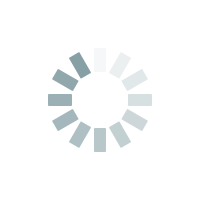
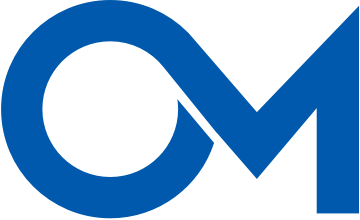
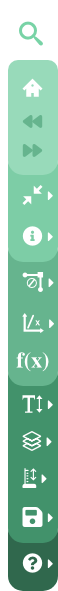

In [28]:
## PLOT N2 DIAGRAM TO INSPECT YOUR PROBLEM SETUP

n2(problem, display_in_notebook=True)

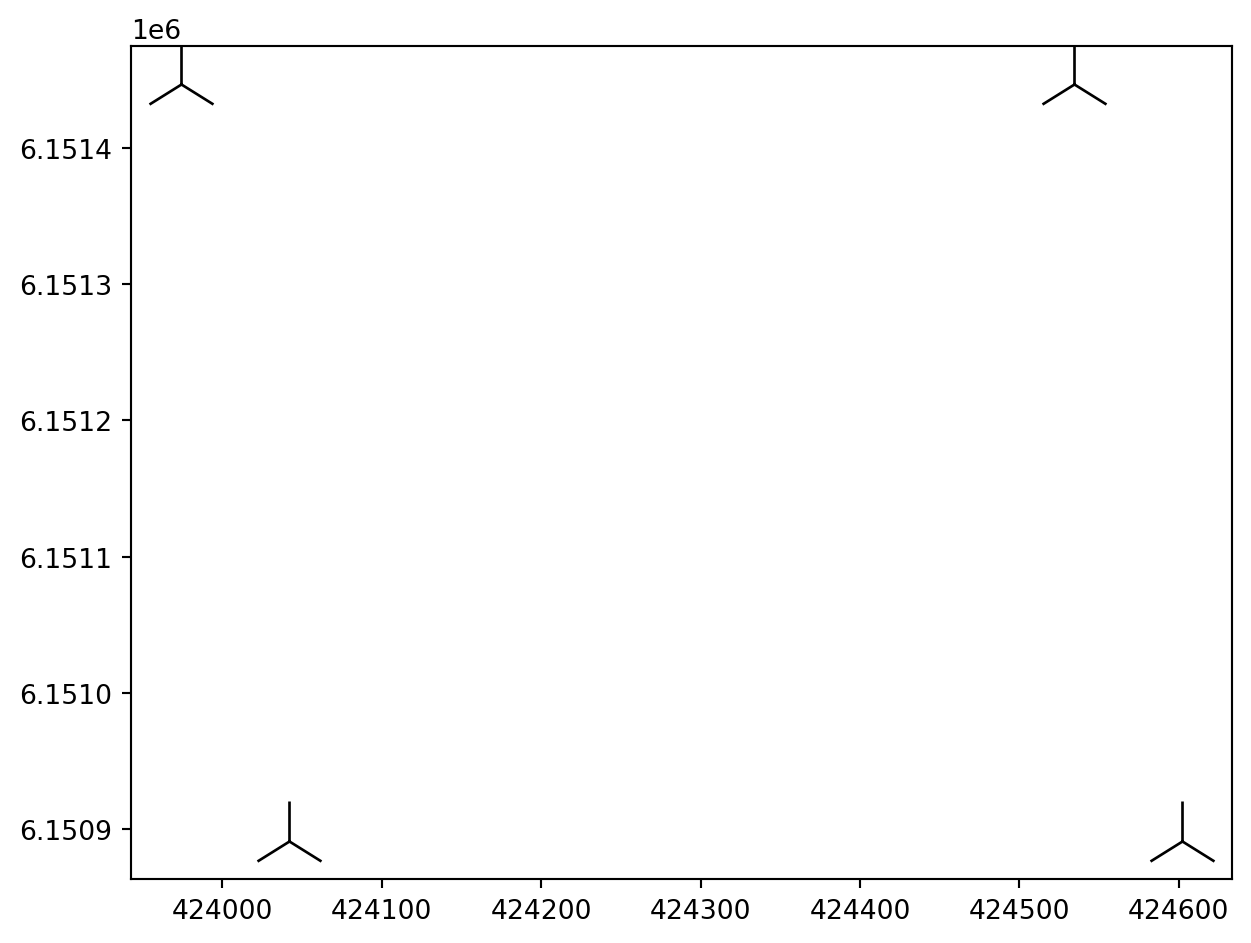

In [30]:
## PLOT WIND FARM

plt.plot(x_init, y_init, '2k', markersize=30)

Text(0, 0.5, 'npv [EUR]')

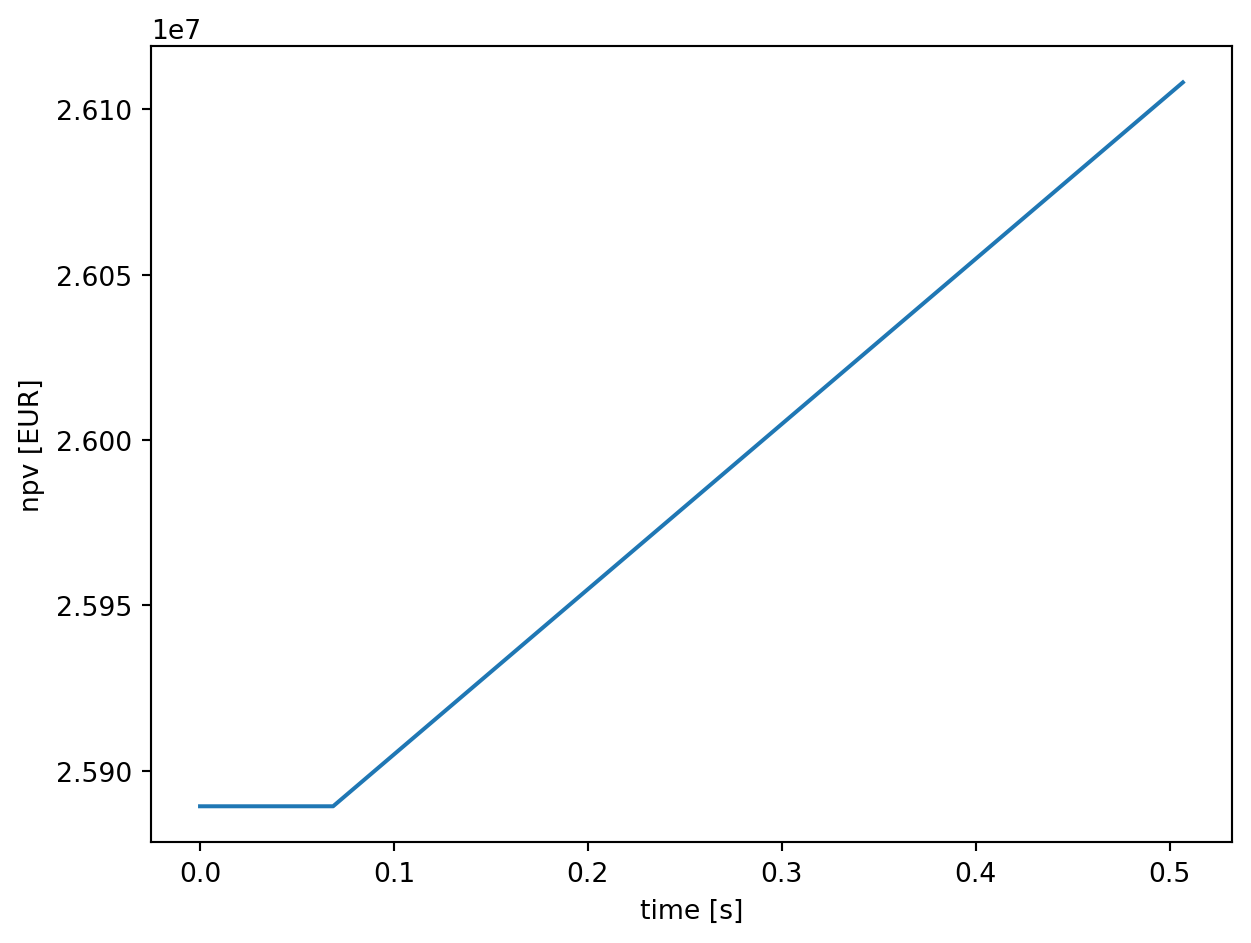

In [31]:
## ACCESSING DATA

fig = plt.figure()
plt.plot(recorder['timestamp']-recorder['timestamp'][0], recorder['npv'])
plt.xlabel("time [s]")
plt.ylabel("npv [EUR]")


In [32]:
problem['CAPEX']

array([56142803.64482063])

In [33]:
problem["OPEX"]

array([4126800.])